In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm 
from PIL import Image

In [3]:
device = "cuda"
batch_size = 256

DATA_PATH = "/home/yhna/SleepEDF_IMG/"
FILE_NAME = "sc_exclude_temp&event_label_O_30mWake_rmMove&?label"
DATASET = "Sleep-EDF-2018"

img_height = 224
img_width = 224

LABEL_NAME = ['Wake', 'N1', 'N2', 'N3', 'REM']

lr_start = 0.0001
lr_min = 0.00005
epochs = 100
num_worker = 8

class SimCLRTransform:
    def __init__(self, size=224):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # 밝기, 대비, 채도, 색조 변화
            ], p=0.8),
            transforms.Lambda(lambda image: image.convert('RGB')),  # RGBA를 RGB로 변환
            transforms.ToTensor(),
        ])
    
    def __call__(self, x):
        return self.transform(x), self.transform(x)

In [4]:
class EEGDataLoader(Dataset):

    def __init__(self, transforms, fold, dset_name, dataset_path, file_name, set='train'):

        self.set = set
        self.fold = fold

        self.Hz = 100        
        
        self.dset_name = dset_name
        self.dataset_path = dataset_path
        self.file_name = file_name
        
        self.file_path = self.split_dataset()
        self.transforms = transforms

    def __len__(self):
        return len(self.file_path)

    def __getitem__(self, idx):
        
        
        img_path = self.file_path[idx]
        
        img = Image.open(img_path)
        label_str = img_path[-5]
        
        if label_str == "W": label = 0
        elif label_str == "1": label = 1
        elif label_str == "2": label = 2
        elif label_str == "3": label = 3
        elif label_str == "4": label = 3
        elif label_str == "R": label = 4
            
        if self.transforms is not None:
            img = self.transforms(img)
                    
        return img, label

    
    def split_dataset(self):
        
        file_idx = 0
        inputs, labels, spc, epochs = [], [], [], []
#         data_root = os.path.join(self.dataset_path)
        data_fname_list = os.listdir(os.path.join(self.dataset_path, self.file_name))
        data_fname_dict = {'train': [], 'test': [], 'val': []}
        split_idx_list = np.load(os.path.join(self.dataset_path, 'split_idx', 'idx_{}.npy'.format(self.dset_name)), allow_pickle=True)
    
        if self.dset_name == 'Sleep-EDF-2013':
            for i in range(len(data_fname_list)):
                subject_idx = int(data_fname_list[i][3:5])
                if subject_idx == self.fold - 1:
                    data_fname_dict['test'].append(data_fname_list[i])
                elif subject_idx in split_idx_list[self.fold - 1]:
                    data_fname_dict['val'].append(data_fname_list[i])
                else:
                    data_fname_dict['train'].append(data_fname_list[i])    

        elif self.dset_name == 'Sleep-EDF-2018':
            for i in range(len(data_fname_list)):
                subject_idx = int(data_fname_list[i][3:5])
                if subject_idx in split_idx_list[self.fold - 1][self.set]:
                    data_fname_dict[self.set].append(data_fname_list[i])

        else:
            raise NameError("dataset '{}' cannot be found.".format(self.dataset))
            
        cnt,file_idx = 0, 0
        file_path = []
        for data_fname in tqdm(data_fname_dict[self.set]):
            base_path = os.path.join(self.dataset_path, self.file_name, data_fname)
            img_files = os.listdir(base_path)
            for img in img_files:
                file_path.append(os.path.join(base_path, img))
            
        return file_path
    
fold = 1
train_dataloader_args = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_worker}
valid_dataloader_args = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_worker}
train_dataset = EEGDataLoader(SimCLRTransform(), fold, DATASET, DATA_PATH, FILE_NAME, set='train')
val_dataset = EEGDataLoader(SimCLRTransform(), fold, DATASET, DATA_PATH, FILE_NAME, set='val')
test_dataset = EEGDataLoader(SimCLRTransform(), fold, DATASET, DATA_PATH, FILE_NAME, set='test')

train_loader = DataLoader(dataset=train_dataset, **train_dataloader_args)
val_loader = DataLoader(dataset=val_dataset, **valid_dataloader_args)
test_loader = DataLoader(dataset=test_dataset, **valid_dataloader_args)

100%|██████████| 16/16 [00:00<00:00, 655.91it/s]


In [5]:
class SimCLR_Loss(nn.Module):
    def __init__(self, temperature):
        super().__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        N = 2 * batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        # 마스크를 동적으로 생성
        mask = torch.ones((N, N), dtype=bool).fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0

        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)
        
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[mask].reshape(N, -1)
        
        labels = torch.zeros(N).to(positive_samples.device).long()  # 더 간단한 방법으로 라벨 생성
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss


# 예를 들어, 배치 크기가 64고 온도 파라미터가 0.5 인 경우
loss_fn = SimCLR_Loss(temperature=0.07)

In [6]:
# SimCLR 모델 정의
class SimCLR(nn.Module):
    def __init__(self, base_model, projection_dim=128):
        super(SimCLR, self).__init__()
        self.base_model = base_model(weights=None)
        self.base_model.fc = nn.Identity()  # 마지막 계층 제거
        features_dim = 512
        
        self.projection_head = nn.Sequential(
            nn.Linear(features_dim, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim),
        )
    
    def forward(self, x):
        x_i, x_j = x
        h_i = self.base_model(x_i)
        h_j = self.base_model(x_j)
        
        z_i = self.projection_head(h_i)
        z_j = self.projection_head(h_j)
        
        return z_i, z_j

model = SimCLR(base_model=models.resnet18)
model = nn.DataParallel(model).to(device)
# criterion = nn.CosineSimilarity(dim=1)
criterion = loss_fn
optimizer = optim.Adam(model.parameters(), lr=0.001)


def validate(model, valid_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for (x_i, x_j), _ in valid_loader:
            x_i, x_j = x_i.to(device), x_j.to(device)
            z_i, z_j = model((x_i, x_j))
            loss = criterion(z_i, z_j)
            total_loss += loss.item()
    return total_loss / len(valid_loader)

# 학습 과정
def train(model, train_loader, valid_loader, criterion, optimizer, epochs=50, patience=5):
    best_loss = float('inf')
    early_stopping_counter = 0
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for (x_i, x_j), _ in tqdm(train_loader):
            optimizer.zero_grad()
            x_i = x_i.to(device)
            x_j = x_j.to(device)
            
            z_i, z_j = model((x_i, x_j))  # 이미지 쌍을 튜플로 묶어 전달
            loss = torch.mean(criterion(z_i, z_j))
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
            
        avg_train_loss = total_loss / len(train_loader)
        avg_valid_loss = validate(model, valid_loader, criterion)
        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Valid Loss: {avg_valid_loss}')
        
        # Early stopping logic
        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            torch.save(model.module.state_dict(), 'best_model_simCLR_SleepEDF.pth')
            early_stopping_counter = 0
            print(f"Early Stopping Count: {early_stopping_counter}")
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping")
                break
    
print("================ Training START ================")
train(model, train_loader, val_loader, criterion, optimizer)

================ Training START ================


100%|██████████| 642/642 [09:50<00:00,  1.09it/s]


Epoch 1, Train Loss: 3.8597359757557093, Valid Loss: 4.596702494863736
Early Stopping Count: 0


100%|██████████| 642/642 [09:32<00:00,  1.12it/s]


Epoch 2, Train Loss: 2.532899690008609, Valid Loss: 4.17843631566581
Early Stopping Count: 0


100%|██████████| 642/642 [09:29<00:00,  1.13it/s]


Epoch 3, Train Loss: 2.0869513323002513, Valid Loss: 4.062232502436234
Early Stopping Count: 0


100%|██████████| 642/642 [09:33<00:00,  1.12it/s]


Epoch 4, Train Loss: 1.8539019761798539, Valid Loss: 3.9099174354035977
Early Stopping Count: 0


100%|██████████| 642/642 [09:30<00:00,  1.13it/s]


Epoch 5, Train Loss: 1.7083018858484762, Valid Loss: 3.7926886303950162
Early Stopping Count: 0


100%|██████████| 642/642 [09:30<00:00,  1.13it/s]


Epoch 6, Train Loss: 1.6032417021065115, Valid Loss: 3.9134667121757896


100%|██████████| 642/642 [09:28<00:00,  1.13it/s]


Epoch 7, Train Loss: 1.5417392684663196, Valid Loss: 3.921397534467406


100%|██████████| 642/642 [09:26<00:00,  1.13it/s]


Epoch 8, Train Loss: 1.4886449842809517, Valid Loss: 3.764697822473817
Early Stopping Count: 0


100%|██████████| 642/642 [09:26<00:00,  1.13it/s]


Epoch 9, Train Loss: 1.441559110846475, Valid Loss: 3.657113127789255
Early Stopping Count: 0


100%|██████████| 642/642 [09:32<00:00,  1.12it/s]


Epoch 10, Train Loss: 1.392903542221521, Valid Loss: 3.590538049148301
Early Stopping Count: 0


100%|██████████| 642/642 [09:27<00:00,  1.13it/s]


Epoch 11, Train Loss: 1.3632572328561563, Valid Loss: 3.5590676412744036
Early Stopping Count: 0


100%|██████████| 642/642 [09:29<00:00,  1.13it/s]


Epoch 12, Train Loss: 1.344984054101219, Valid Loss: 3.5433909286886958
Early Stopping Count: 0


100%|██████████| 642/642 [09:24<00:00,  1.14it/s]


Epoch 13, Train Loss: 1.3191431081183602, Valid Loss: 3.5305216352818376
Early Stopping Count: 0


100%|██████████| 642/642 [09:25<00:00,  1.13it/s]


Epoch 14, Train Loss: 1.3006315350161164, Valid Loss: 3.5779979350203175


100%|██████████| 642/642 [09:27<00:00,  1.13it/s]


Epoch 15, Train Loss: 1.2575707378045793, Valid Loss: 3.4261681467799816
Early Stopping Count: 0


100%|██████████| 642/642 [09:29<00:00,  1.13it/s]


Epoch 16, Train Loss: 1.2674195545484714, Valid Loss: 3.457551503585557


100%|██████████| 642/642 [08:56<00:00,  1.20it/s]


Epoch 17, Train Loss: 1.2387918393559916, Valid Loss: 3.504194881956456


100%|██████████| 642/642 [09:02<00:00,  1.18it/s]


Epoch 18, Train Loss: 1.2187683189583716, Valid Loss: 3.438877443135795


100%|██████████| 642/642 [09:04<00:00,  1.18it/s]


Epoch 19, Train Loss: 1.1953775772238817, Valid Loss: 3.404472926915702
Early Stopping Count: 0


100%|██████████| 642/642 [08:39<00:00,  1.23it/s]


Epoch 20, Train Loss: 1.1770889145377268, Valid Loss: 3.3749633481947043
Early Stopping Count: 0


100%|██████████| 642/642 [08:53<00:00,  1.20it/s]


Epoch 21, Train Loss: 1.1719500832839918, Valid Loss: 3.409132028030137


100%|██████████| 642/642 [08:53<00:00,  1.20it/s]


Epoch 22, Train Loss: 1.1712042380159147, Valid Loss: 3.3328969276557534
Early Stopping Count: 0


100%|██████████| 642/642 [08:54<00:00,  1.20it/s]


Epoch 23, Train Loss: 1.1462816859702827, Valid Loss: 3.436011827598184


100%|██████████| 642/642 [08:54<00:00,  1.20it/s]


Epoch 25, Train Loss: 1.144316449157917, Valid Loss: 3.3508831040333895


100%|██████████| 642/642 [09:06<00:00,  1.17it/s]


Epoch 26, Train Loss: 1.1323690076483373, Valid Loss: 3.2816020634214755
Early Stopping Count: 0


100%|██████████| 642/642 [09:05<00:00,  1.18it/s]


Epoch 27, Train Loss: 1.1282889465119608, Valid Loss: 3.2336834002349337
Early Stopping Count: 0


100%|██████████| 642/642 [09:07<00:00,  1.17it/s]


Epoch 28, Train Loss: 1.1094382685664286, Valid Loss: 3.2928956767260016


100%|██████████| 642/642 [09:22<00:00,  1.14it/s]


Epoch 29, Train Loss: 1.0969569950460274, Valid Loss: 3.276273581941249


100%|██████████| 642/642 [09:24<00:00,  1.14it/s]


Epoch 30, Train Loss: 1.1013853850765762, Valid Loss: 3.2267819723840487
Early Stopping Count: 0


100%|██████████| 642/642 [09:27<00:00,  1.13it/s]


Epoch 31, Train Loss: 1.0842936079821484, Valid Loss: 3.214067442942474
Early Stopping Count: 0


100%|██████████| 642/642 [08:59<00:00,  1.19it/s]


Epoch 32, Train Loss: 1.0836955992232231, Valid Loss: 3.2205485550023742


100%|██████████| 642/642 [09:03<00:00,  1.18it/s]


Epoch 33, Train Loss: 1.0735060661752647, Valid Loss: 3.2776557146492653


100%|██████████| 642/642 [09:26<00:00,  1.13it/s]


Epoch 34, Train Loss: 1.0690745943431914, Valid Loss: 3.2558252629587208


100%|██████████| 642/642 [09:20<00:00,  1.15it/s]


Epoch 35, Train Loss: 1.0700492340827656, Valid Loss: 3.211297962625148
Early Stopping Count: 0


100%|██████████| 642/642 [09:06<00:00,  1.17it/s]


Epoch 36, Train Loss: 1.051897314385833, Valid Loss: 3.1994258710893533
Early Stopping Count: 0


100%|██████████| 642/642 [09:26<00:00,  1.13it/s]


Epoch 37, Train Loss: 1.0552423380059988, Valid Loss: 3.2089864217628867


100%|██████████| 642/642 [08:56<00:00,  1.20it/s]


Epoch 38, Train Loss: 1.047318837074476, Valid Loss: 3.2186565601219566


100%|██████████| 642/642 [09:00<00:00,  1.19it/s]


Epoch 39, Train Loss: 1.0397466330142036, Valid Loss: 3.2474319207466253


100%|██████████| 642/642 [08:53<00:00,  1.20it/s]


Epoch 40, Train Loss: 1.0348902250004706, Valid Loss: 3.1905297485448547
Early Stopping Count: 0


100%|██████████| 642/642 [09:00<00:00,  1.19it/s]


Epoch 41, Train Loss: 1.0377763030684997, Valid Loss: 3.2208034729553483


100%|██████████| 642/642 [08:37<00:00,  1.24it/s]


Epoch 42, Train Loss: 1.042425389323279, Valid Loss: 3.185254319239471
Early Stopping Count: 0


100%|██████████| 642/642 [08:58<00:00,  1.19it/s]


Epoch 43, Train Loss: 1.0186372853328134, Valid Loss: 3.236222958160659


100%|██████████| 642/642 [09:06<00:00,  1.17it/s]


Epoch 44, Train Loss: 1.0269347955690367, Valid Loss: 3.155317439871319
Early Stopping Count: 0


100%|██████████| 642/642 [08:57<00:00,  1.19it/s]


Epoch 45, Train Loss: 1.0180633197135271, Valid Loss: 3.196733383809106


100%|██████████| 642/642 [08:51<00:00,  1.21it/s]


Epoch 46, Train Loss: 1.0173666730662372, Valid Loss: 3.168453778250743


100%|██████████| 642/642 [08:42<00:00,  1.23it/s]


Epoch 47, Train Loss: 1.0100926351138735, Valid Loss: 3.0807707895666865
Early Stopping Count: 0


100%|██████████| 642/642 [09:00<00:00,  1.19it/s]


Epoch 48, Train Loss: 0.9998072040415256, Valid Loss: 3.1336949558581337


100%|██████████| 642/642 [08:58<00:00,  1.19it/s]


Epoch 49, Train Loss: 0.9891026309717481, Valid Loss: 3.113355311296754


100%|██████████| 642/642 [08:55<00:00,  1.20it/s]


Epoch 50, Train Loss: 0.9995836883876182, Valid Loss: 3.107940374794653


In [7]:
# Top Layer 추가: 예를 들어, CIFAR-10의 경우 10개의 클래스가 있습니다.


class SimCLR(nn.Module):
    def __init__(self, base_model, num_classes):
        super(SimCLR, self).__init__()
        self.base_model = base_model(pretrained=False)
        
        # base_model의 마지막 fully connected layer를 제거합니다.
        self.base_model.fc = nn.Identity()
        
        # 분류를 위한 새로운 레이어를 추가합니다.
        self.fc = nn.Linear(512, num_classes)  # ResNet18 기준으로 512는 feature dimension입니다.

    def forward(self, x):
        # base_model을 통해 feature를 추출합니다.
        h = self.base_model(x)
        
        # 추출된 feature를 새로운 분류 레이어로 전달합니다.
        out = self.fc(h)
        
        return out


model = SimCLR(base_model=models.resnet18, num_classes=10)
checkpoint = torch.load("./best_model_simCLR_SleepEDF.pth")
checkpoint = {k:v for k, v in checkpoint.items() if "projection_head" not in k}
num_classes, num_features = 10, 512
fc_weights = torch.nn.init.xavier_uniform_(torch.empty(num_classes, num_features))
fc_bias = torch.zeros(num_classes)

# Add to checkpoint under the correct keys
checkpoint['fc.weight'] = fc_weights
checkpoint['fc.bias'] = fc_bias


model.load_state_dict(checkpoint, strict=True)
model = nn.DataParallel(model).to(device)


train_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.RandomResizedCrop(size=224),
    transforms.Lambda(lambda image: image.convert('RGB')),  # RGBA를 RGB로 변환
    transforms.ToTensor(),
])

valid_transform = transforms.Compose([
    transforms.Resize(size=224),
    transforms.Lambda(lambda image: image.convert('RGB')),  # RGBA를 RGB로 변환
    transforms.ToTensor(),
])

# Fine-tuning을 위한 데이터셋 준비

train_dataloader_args = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_worker}
valid_dataloader_args = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_worker}
train_dataset = EEGDataLoader(train_transform, fold, DATASET, DATA_PATH, FILE_NAME, set='train')
val_dataset = EEGDataLoader(valid_transform, fold, DATASET, DATA_PATH, FILE_NAME, set='val')
test_dataset = EEGDataLoader(valid_transform, fold, DATASET, DATA_PATH, FILE_NAME, set='test')

train_loader = DataLoader(dataset=train_dataset, **train_dataloader_args)
val_loader = DataLoader(dataset=val_dataset, **valid_dataloader_args)
test_loader = DataLoader(dataset=test_dataset, **valid_dataloader_args)


# Optimizer와 Loss Function 설정
optimizer = optim.Adam(model.parameters(), lr=1e-4) # 보통 fine-tuning은 낮은 학습률을 사용합니다.
criterion = nn.CrossEntropyLoss() # 분류 작업을 위한 Cross Entropy Loss


def fine_tune(model, train_loader, val_loader, criterion, optimizer, epochs=100, device='cuda'):
    model.to(device)
    best_acc = 0
    patience = 5
    
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        correct = 0
        total = 0

        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct / total
        
        
        # Early stopping logic
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.module.state_dict(), 'best_model_finetune_simCLR_SleepEDF.pth')
            early_stopping_counter = 0
            print(f"Early Stopping Count: {early_stopping_counter}")
        else:
            early_stopping_counter += 1
            print(f"Early Stopping Count: {early_stopping_counter}")
            if early_stopping_counter >= patience:
                print("Early stopping")
                break

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

print("================ Fine-tuning START ================")
# Assuming `fine_tune_loader` is your training loader and `val_loader` is your validation loader
fine_tune(model, train_loader, val_loader, criterion, optimizer, device=device)
print("================ Checking-TEST START ================")
fine_tune(model, val_loader, test_loader, criterion, optimizer, device=device, epochs = 1)

/home/yhna/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yhna/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 16/16 [00:00<00:00, 692.73it/s]


================ Fine-tuning START ================


100%|██████████| 59/59 [00:55<00:00,  1.07it/s]


Early Stopping Count: 0
Epoch 1, Train Loss: 0.9486, Train Accuracy: 0.6594, Val Loss: 0.6827, Val Accuracy: 0.7334


100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Early Stopping Count: 0
Epoch 2, Train Loss: 0.6962, Train Accuracy: 0.7325, Val Loss: 0.6308, Val Accuracy: 0.7519


100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Early Stopping Count: 0
Epoch 3, Train Loss: 0.6668, Train Accuracy: 0.7425, Val Loss: 0.6280, Val Accuracy: 0.7555


100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Early Stopping Count: 1
Epoch 4, Train Loss: 0.6490, Train Accuracy: 0.7479, Val Loss: 0.6391, Val Accuracy: 0.7512


100%|██████████| 59/59 [00:54<00:00,  1.09it/s]


Early Stopping Count: 2
Epoch 5, Train Loss: 0.6381, Train Accuracy: 0.7539, Val Loss: 0.6444, Val Accuracy: 0.7493


100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Early Stopping Count: 0
Epoch 6, Train Loss: 0.6301, Train Accuracy: 0.7556, Val Loss: 0.6185, Val Accuracy: 0.7575


100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Early Stopping Count: 0
Epoch 7, Train Loss: 0.6227, Train Accuracy: 0.7599, Val Loss: 0.6156, Val Accuracy: 0.7583


100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Early Stopping Count: 1
Epoch 8, Train Loss: 0.6173, Train Accuracy: 0.7607, Val Loss: 0.6076, Val Accuracy: 0.7554


100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Early Stopping Count: 2
Epoch 9, Train Loss: 0.6127, Train Accuracy: 0.7626, Val Loss: 0.6140, Val Accuracy: 0.7573


100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Early Stopping Count: 3
Epoch 10, Train Loss: 0.6045, Train Accuracy: 0.7658, Val Loss: 0.6131, Val Accuracy: 0.7556


100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Early Stopping Count: 0
Epoch 11, Train Loss: 0.6022, Train Accuracy: 0.7657, Val Loss: 0.6076, Val Accuracy: 0.7624


100%|██████████| 59/59 [00:54<00:00,  1.08it/s]


Early Stopping Count: 0
Epoch 12, Train Loss: 0.5988, Train Accuracy: 0.7686, Val Loss: 0.6039, Val Accuracy: 0.7629


100%|██████████| 59/59 [00:54<00:00,  1.09it/s]


Early Stopping Count: 0
Epoch 13, Train Loss: 0.5966, Train Accuracy: 0.7688, Val Loss: 0.5984, Val Accuracy: 0.7632


100%|██████████| 59/59 [00:54<00:00,  1.09it/s]


Early Stopping Count: 1
Epoch 14, Train Loss: 0.5904, Train Accuracy: 0.7706, Val Loss: 0.6120, Val Accuracy: 0.7606


100%|██████████| 59/59 [00:54<00:00,  1.09it/s]


Early Stopping Count: 2
Epoch 15, Train Loss: 0.5903, Train Accuracy: 0.7707, Val Loss: 0.6226, Val Accuracy: 0.7583


100%|██████████| 59/59 [00:54<00:00,  1.09it/s]


Early Stopping Count: 3
Epoch 16, Train Loss: 0.5878, Train Accuracy: 0.7707, Val Loss: 0.6035, Val Accuracy: 0.7612


100%|██████████| 59/59 [00:54<00:00,  1.07it/s]


Early Stopping Count: 4
Epoch 17, Train Loss: 0.5834, Train Accuracy: 0.7732, Val Loss: 0.6233, Val Accuracy: 0.7551


100%|██████████| 59/59 [00:53<00:00,  1.11it/s]


Early Stopping Count: 5
Early stopping
================ Checking-TEST START ================


100%|██████████| 65/65 [01:00<00:00,  1.08it/s]


Early Stopping Count: 0
Epoch 1, Train Loss: 0.6647, Train Accuracy: 0.7471, Val Loss: 0.5796, Val Accuracy: 0.7798


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

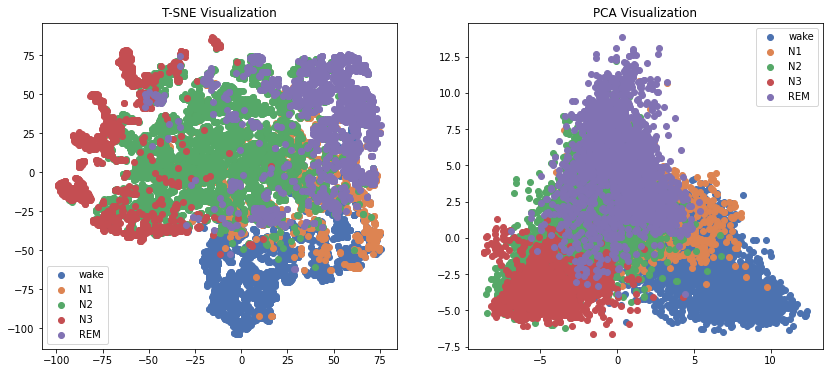

In [9]:
# 특징과 라벨을 추출하는 함수
import seaborn as sns

def extract_features_and_labels(model, loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for x_i, label in loader:
            x_i = x_i.to(device)
            feature = model(x_i).cpu().numpy()
            features.append(feature)
            labels.append(label.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# 시각화 코드는 라벨에 따라 색상을 다르게 할 수 있도록 수정됩니다.
features, labels = extract_features_and_labels(model, val_loader)
tsne_features = TSNE(n_components=2).fit_transform(features)
pca_features = PCA(n_components=2).fit_transform(features)

# 클래스별로 다른 색상을 사용하기 위해 unique labels과 colormap을 준비합니다.
unique_labels = np.unique(labels)
# colors = plt.cm.get_cmap('tab10', len(unique_labels))
palette = sns.color_palette('deep', len(unique_labels))
colors = sns.color_palette(palette)

stage_labels = ['wake', 'N1', 'N2', 'N3', 'REM']

plt.figure(figsize=(14, 6))

# T-SNE 시각화
plt.subplot(1, 2, 1)
for i, label in enumerate(unique_labels):
    plt.scatter(tsne_features[labels == label, 0], tsne_features[labels == label, 1], 
                c=colors[i], label=stage_labels[i])  # 수정된 부분: colors(i) -> colors[i]
plt.title('T-SNE Visualization')
plt.legend()

# PCA 시각화
plt.subplot(1, 2, 2)
for i, label in enumerate(unique_labels):
    plt.scatter(pca_features[labels == label, 0], pca_features[labels == label, 1], 
                c=colors[i], label=stage_labels[i])  # 수정된 부분: colors(i) -> colors[i]
plt.title('PCA Visualization')
plt.legend()

plt.show()